In [81]:
import numpy as np
from scipy import stats
from numpy import nan
import pandas as pd
import s3fs
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import date, timedelta, datetime
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_precision_recall_curve, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier, export_text
import statistics
from matplotlib import pyplot as plt
import multiprocessing
from sf import sf_connection
import logging
import snowflake.connector
import pyarrow
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import boto3
import warnings
import pyarrow.parquet as pq
import s3fs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import statsmodels.api as sm
import pickle


In [2]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
s3 = s3fs.S3FileSystem()
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [4]:
conn = sf_connection()

### Let's read in the features we created

In [5]:
feature_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/score/yes_ecomm.parquet'

In [6]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

### Now we read in the label data

In [7]:
label_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/discount_lables.csv'

In [8]:
label_table = pd.read_csv(label_path, header=0)

In [9]:
len(feature_table.drop_duplicates('INDV_ID')), len(label_table.drop_duplicates('INDV_ID'))

(22529095, 22327757)

### Now we inner join on INDV_ID

In [10]:
combined_table = pd.merge(feature_table, label_table, on='INDV_ID', how='inner')

In [11]:
len(combined_table)

22325083

In [12]:
combined_table.drop_duplicates('INDV_ID', inplace=True)

In [13]:
len(combined_table)

22325083

## We now create three more features

In [14]:
combined_table['ecomm_frac'] = combined_table['numEcom']/combined_table['numPurchase']

In [15]:
combined_table['is_sp'] = combined_table['LOYALTY_NUMBER'].apply(lambda x: 1 if x > 0 else 0)

In [16]:
combined_table['is_ecomm'] = combined_table['ecomm_frac'].apply(lambda x: 1 if x > 0.0 else 0)

### Only model customers with ecommerce engagement  - we will predict customers without eComm engatement as 'not discount sensitive'

In [17]:
ecomm_table = combined_table[combined_table.is_ecomm==1].copy()

In [18]:
no_ecomm_table = combined_table[combined_table.is_ecomm==0].copy()

In [19]:
len(ecomm_table)

3489566

### Now we join with dim_store to get the market type

In [20]:
store_query = """select STORE_NUMBER, MARKET_CLASS_CODE from PEDW.LOCATION.DIM_STORE_V"""

In [21]:
store_xref = pd.read_sql(store_query, conn)

In [22]:
len(store_xref)

7620

In [23]:
store_xref = store_xref[store_xref.MARKET_CLASS_CODE != 'UNKNOWN'].copy()

In [24]:
len(store_xref)

6009

In [25]:
store_xref['MARKET_CLASS_CODE'] = store_xref['MARKET_CLASS_CODE'].apply(lambda x: int(x))

In [26]:
store_xref.dtypes

STORE_NUMBER         int64
MARKET_CLASS_CODE    int64
dtype: object

In [27]:
store_xref.rename(columns={'STORE_NUMBER': 'FULLFILLMENT_STORE_NUMBER'}, inplace=True)

### Now let's look at distances to AAP and competitor stores

In [28]:
aap_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V 
    where (INDV_ID, STORE_NUMBER, LOAD_TS) in (select INDV_ID, STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V
                                                group by INDV_ID, STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [29]:
aap_dist = pd.read_sql(aap_query, conn)

In [30]:
len(aap_dist)

119686380

In [31]:
comp_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
    where (INDV_ID, CMP_STORE_NUMBER, LOAD_TS) in (select INDV_ID, CMP_STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
                                                group by INDV_ID, CMP_STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [32]:
comp_dist = pd.read_sql(comp_query, conn)

In [33]:
len(comp_dist)

121056446

In [34]:
aap_dist = aap_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'AAP_DIST'})

In [35]:
comp_dist = comp_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'CMP_DIST'})

In [36]:
len(aap_dist), len(aap_dist.drop_duplicates('INDV_ID'))

(119686380, 119686380)

In [37]:
len(comp_dist), len(comp_dist.drop_duplicates('INDV_ID'))

(121056446, 121056446)

### Now we join these dataframes to the combined table and fill nas

#### First the market code

In [38]:
ecomm_table = pd.merge(ecomm_table, store_xref, how='left', on='FULLFILLMENT_STORE_NUMBER')

In [39]:
ecomm_table.isnull().sum()

INDV_ID                                         0
fyGross                                         0
2hGross                                         0
4qGross                                         0
fyNet                                           0
2hNet                                           0
4qNet                                           0
numEcom                                         0
numPurchase                                     0
Recency                                         0
daysSinceLastPurchase                           0
isEmployee                                      0
numReturn                                       0
numCoupon                                       0
LOYALTY_NUMBER                                  0
meanPurchaseTransaction                         0
FULLFILLMENT_STORE_NUMBER                       0
pop_est_cy                                      0
pop_density_cy                                  0
pct_white                                       0


#### Fill nulls with 0

In [40]:
ecomm_table.fillna(0, inplace=True)

#### Now aap store distances

In [41]:
ecomm_table = pd.merge(ecomm_table, aap_dist, how='left', on='INDV_ID')

In [42]:
ecomm_table.isna().sum()

INDV_ID                                         0
fyGross                                         0
2hGross                                         0
4qGross                                         0
fyNet                                           0
2hNet                                           0
4qNet                                           0
numEcom                                         0
numPurchase                                     0
Recency                                         0
daysSinceLastPurchase                           0
isEmployee                                      0
numReturn                                       0
numCoupon                                       0
LOYALTY_NUMBER                                  0
meanPurchaseTransaction                         0
FULLFILLMENT_STORE_NUMBER                       0
pop_est_cy                                      0
pop_density_cy                                  0
pct_white                                       0


In [43]:
ecomm_table['AAP_DIST'] = ecomm_table['AAP_DIST'].fillna(ecomm_table['AAP_DIST'].mean())

#### Now competitor store distances

In [44]:
ecomm_table = pd.merge(ecomm_table, comp_dist, how='left', on='INDV_ID')

In [45]:
ecomm_table.isna().sum()

INDV_ID                                        0
fyGross                                        0
2hGross                                        0
4qGross                                        0
fyNet                                          0
2hNet                                          0
4qNet                                          0
numEcom                                        0
numPurchase                                    0
Recency                                        0
daysSinceLastPurchase                          0
isEmployee                                     0
numReturn                                      0
numCoupon                                      0
LOYALTY_NUMBER                                 0
meanPurchaseTransaction                        0
FULLFILLMENT_STORE_NUMBER                      0
pop_est_cy                                     0
pop_density_cy                                 0
pct_white                                      0
age                 

In [46]:
ecomm_table['CMP_DIST'] = ecomm_table['CMP_DIST'].fillna(ecomm_table['CMP_DIST'].mean())

In [47]:
ecomm_table['aap_closer_by'] = ecomm_table['CMP_DIST'] - ecomm_table['AAP_DIST']

In [48]:
ecomm_table['comp_dist_ratio'] = ecomm_table['CMP_DIST']/ecomm_table['AAP_DIST']

### Now let's get the customer lifetime (tenure)

In [49]:
tenure_query = """
    select 
        INDV_ID, 
        datediff(day, INDV_FIRST_TRANSACTION_DATE, '2021-03-01') as TENURE
    from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
    where (INDV_ID,LOAD_TS) in
        (select INDV_ID, max(LOAD_TS) from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
        group by INDV_ID)
        """

In [50]:
tenure = pd.read_sql(tenure_query, conn)

In [51]:
tenure.dtypes

INDV_ID    int64
TENURE     int64
dtype: object

In [52]:
tenure.head()

INDV_ID  TENURE
0  632812380     195
1  191241874    2786
2  136018218     732
3  632810735     196
4  296696163    1682

In [53]:
ecomm_table = pd.merge(ecomm_table, tenure, how='left', on='INDV_ID')

In [54]:
ecomm_table.isna().sum()

INDV_ID                                    0
fyGross                                    0
2hGross                                    0
4qGross                                    0
fyNet                                      0
2hNet                                      0
4qNet                                      0
numEcom                                    0
numPurchase                                0
Recency                                    0
daysSinceLastPurchase                      0
isEmployee                                 0
numReturn                                  0
numCoupon                                  0
LOYALTY_NUMBER                             0
meanPurchaseTransaction                    0
FULLFILLMENT_STORE_NUMBER                  0
pop_est_cy                                 0
pop_density_cy                             0
pct_white                                  0
age                                        0
pct_college                                0
pct_blue_c

In [55]:
ecomm_table.loc[(ecomm_table.TENURE < 1), 'TENURE'] = 1

In [56]:
features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'TOTAL',
     'Sends',
     'Revenue',
     'OpenRate',
     'ClickRate',
     'ConversionRate',
     'numSessions',
     'meanHits',
     'meanPages',
     'meanRemovals',
     'meanPurchases',
     'meanAdditions',
     'meanCheckouts',
     'meanAbandoned',
     'meanQuality',
     'meanTime',
     'acura',
     'audi',
     'bmw',
     'bick',
     'cadillac',
     'chevrolet',
     'chrysler',
     'dodge',
     'ford',
     'gmc',
     'harleydavidson',
     'honda',
     'hyundai',
     'infiniti',
     'isuzu',
     'jaguar',
     'jeep',
     'kia',
     'landrover',
     'lexus',
     'lincoln',
     'mazda',
     'mercedesbenz',
     'mercury',
     'mini',
     'mitsubishi',
     'nissan',
     'oldsmobile',
     'plymouth',
     'pontiac',
     'ram',
     'saab',
     'saturn',
     'scion',
     'subaru',
     'suzuki',
     'toyota',
     'volkswagen',
     'volvo',
     'yamaha',
     'maxVehicleAge',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [57]:
label = ['3quarter']

In [58]:
ecomm_table = ecomm_table[features + label]

### Now we evaluate the class balance

In [59]:
summary = ecomm_table.groupby(label)['TENURE'].count().reset_index()

In [60]:
summary['FRACTION'] = summary['TENURE']/summary['TENURE'].sum()

In [61]:
summary

3quarter   TENURE             FRACTION
0         0  1658984                0.475
1         1  1830582                0.525

### We one-hot encode market class

In [62]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto', dtype=np.int, handle_unknown='ignore')

In [63]:
market_class_feature = onehot_encoder.fit_transform(ecomm_table[['MARKET_CLASS_CODE']])


In [64]:
market_class_feature.shape

(3489566, 8)

In [65]:
market_categories = [cat for cat in onehot_encoder.categories_[0]]

In [66]:
market_categories

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [67]:
market_categories_dict = {0: 'zero', 
                             1: 'one',
                             2: 'two',
                             3: 'three',
                             4: 'four',
                             5: 'five',
                             6: 'six',
                             7: 'seven'}

In [68]:
market_categories = list(map(market_categories_dict.get, market_categories))

In [69]:
market_class_dataframe = pd.DataFrame(market_class_feature)
market_class_dataframe.columns = market_categories

In [70]:
market_class_dataframe.head()

zero  one  two  three  four  five  six  seven
0     0    0    0      0     0     0    1      0
1     0    0    0      0     1     0    0      0
2     0    0    0      1     0     0    0      0
3     0    0    0      0     0     0    1      0
4     0    0    0      0     0     1    0      0

In [71]:
ecomm_table.reset_index(drop=True, inplace=True)

In [72]:
len(ecomm_table), len(market_class_dataframe)

(3489566, 3489566)

In [73]:
ecomm_table = pd.merge(ecomm_table, market_class_dataframe, left_index=True, right_index=True)

In [74]:
ecomm_table[market_categories + ['MARKET_CLASS_CODE']].head(20)

zero  one  two  three  four  five  six  seven    MARKET_CLASS_CODE
0      0    0    0      0     0     0    1      0                6.000
1      0    0    0      0     1     0    0      0                4.000
2      0    0    0      1     0     0    0      0                3.000
3      0    0    0      0     0     0    1      0                6.000
4      0    0    0      0     0     1    0      0                5.000
5      0    0    0      0     0     1    0      0                5.000
6      0    0    0      0     0     1    0      0                5.000
7      0    0    0      0     1     0    0      0                4.000
8      0    0    0      0     1     0    0      0                4.000
9      0    0    0      0     0     0    1      0                6.000
10     0    0    0      0     0     1    0      0                5.000
11     0    0    0      0     0     1    0      0                5.000
12     0    0    0      0     0     0    1      0                6.000
13     1    0    0      0     0     0    0      0                0.000
14     0    0    0      0     0     0    1      0                6.000
15     0    0    0      0     0     0    1      0                6.000
16     0    0    0      0     1     0    0      0                4.000
17     0    0    0      0     0     1    0      0                5.000
18     0    0    0      0     1     0    0      0                4.000
19     0    0    0      0     1     0    0      0                4.000

In [75]:
ecomm_table.drop(columns={'MARKET_CLASS_CODE'}, inplace=True)

In [76]:
features = [feature for feature in features if feature != 'MARKET_CLASS_CODE']

### Now we split the data into train and test

In [77]:
X_train, X_test, y_train, y_test = train_test_split(ecomm_table[features], ecomm_table[label], 
                                                    test_size=0.10, random_state=1, stratify=ecomm_table[label])

### We lock up the test (holdout) set in a vault, and split the training set into use and validate.  We will use the validation set for tuning

In [78]:
X_use, X_validate, y_use, y_validate = train_test_split(X_train, y_train, 
                                                    test_size=0.10, random_state=1, stratify=y_train)

### We fit on the entire training set

In [82]:
simple_model = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=1, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
simple_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [83]:
tree_rules = export_text(simple_model, feature_names=list(X_train.columns))

In [84]:
print(tree_rules)

|--- ecomm_frac <= 0.80
|   |--- class: 0
|--- ecomm_frac >  0.80
|   |--- class: 1



### We now use these tuning parameters to train the model on the entire training set.  We then evaluate the results using the test set.

In [85]:
test_pred = simple_model.predict(X_test)

In [86]:
test_score = simple_model.predict_proba(X_test)

In [87]:
test_score_unpacked = [score[1] for score in test_score]

In [88]:
confusion_matrix(y_test, test_pred)

array([[116677,  49222],
       [  7171, 175887]])

In [89]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.94      0.70      0.81    165899
           1       0.78      0.96      0.86    183058

    accuracy                           0.84    348957
   macro avg       0.86      0.83      0.83    348957
weighted avg       0.86      0.84      0.83    348957



In [90]:
roc_auc_score(y_test,test_score_unpacked)

0.8320640147666652

In [91]:
average_precision_score(y_test, test_score_unpacked, pos_label=1)

0.7712835090238377

Text(0.5, 1.0, 'Precision/Recall Curve, Positive Class is "discount sensitive"')

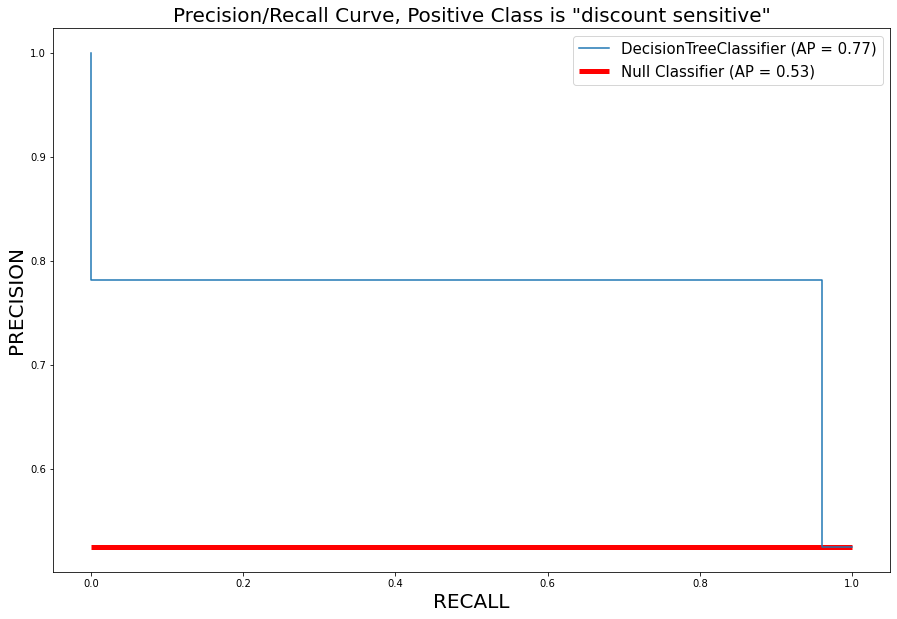

In [93]:
fig = plot_precision_recall_curve(simple_model, X_test, y_test, pos_label=1)
fig.figure_.set_size_inches(15, 10)
plt.hlines(0.525, 0.0, 1.0, colors='red', label="Null Classifier (AP = 0.53)", linewidth=5)
plt.xlabel('RECALL', size='20')
plt.ylabel('PRECISION', size='20')
plt.legend(loc='upper right', fontsize=15)
plt.title('Precision/Recall Curve, Positive Class is "discount sensitive"', size='20')

Text(0.5, 1.0, 'ROC Curve, Positive Class is "discount sensitive"')

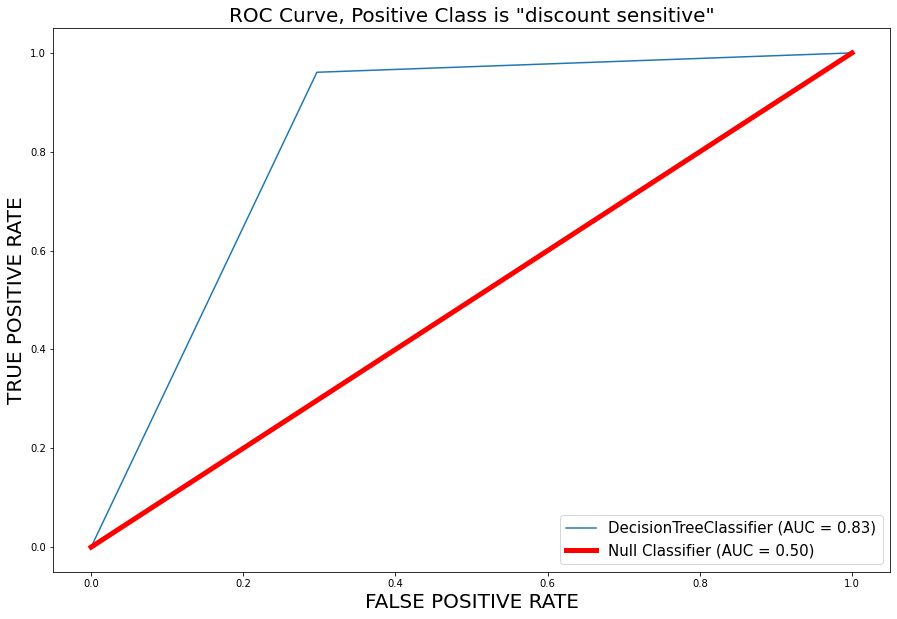

In [94]:
fig = plot_roc_curve(simple_model, X_test, y_test, pos_label=1)
fig.figure_.set_size_inches(15, 10)
fig.ax_.plot([0, 1], [0, 1], 'red', linewidth=5, label="Null Classifier (AUC = 0.50)")
plt.xlabel('FALSE POSITIVE RATE', size='20')
plt.ylabel('TRUE POSITIVE RATE', size='20')
plt.legend(loc='lower right', fontsize=15)
plt.title('ROC Curve, Positive Class is "discount sensitive"', size='20')

In [ ]:
def write_pickle_to_s3(bucket, key, data):
    """Function to write pickle files to s3"""
    
    s3 = boto3.client('s3')
    serialized = pickle.dumps(data)
    s3.put_object(Bucket=bucket, Key=key, Body=serialized)
    
    
def read_pickle_from_s3(bucket, key):
    """Function to read pickle files from s3"""
    
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    
    return pickle.loads(body)

In [ ]:
BUCKET = 'aap-aiexpzone-nonpii-mktg-general-results-prod'
KEY = 'DiscountPreference/Models/XGB/xgb.mod'

In [ ]:
write_pickle_to_s3(BUCKET, KEY, xg_class)

In [ ]:
model = read_pickle_from_s3(BUCKET, KEY)

In [ ]:
type(model)

### Now we process the no_ecomm custmers

In [95]:
len(no_ecomm_table)

18835517

In [96]:
list(no_ecomm_table.columns)

['INDV_ID',
 'fyGross',
 '2hGross',
 '4qGross',
 'fyNet',
 '2hNet',
 '4qNet',
 'numEcom',
 'numPurchase',
 'Recency',
 'daysSinceLastPurchase',
 'isEmployee',
 'numReturn',
 'numCoupon',
 'LOYALTY_NUMBER',
 'meanPurchaseTransaction',
 'FULLFILLMENT_STORE_NUMBER',
 'pop_est_cy',
 'pop_density_cy',
 'pct_white',
 'age',
 'pct_college',
 'pct_blue_collar',
 'median_household_income',
 'establishments',
 'IGNITIONEMISSIONFUELSYSTEMS',
 'ADVANCECARESERVICES',
 'AIRFILTERS',
 'LIGHTING',
 'HDHVAC&HYDRAULICS',
 'COMMERCIALHANDSPECIALTYTOOLS',
 'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
 'WINTER&SUMMERSEASONAL',
 'MOTOROIL',
 'HORNSANDSECURITY',
 'COOLINGSYSTEMRADIATORS',
 'GREASE&GEAR',
 'OILFILTERS',
 'APPEARANCECHEMICALS',
 'HDFILTERS',
 'INTERIORACCESSORIES',
 'HDWHEELEND',
 'BRAKESHARDWARE',
 'OIL&GASACCESSORIES',
 'AIRTOOLS&ACCESSORIES',
 'PERFORMANCE&FUNCTIONALCHEMICALS',
 'STORESUPPLIES&FIXTURES',
 'BRAKESHYDRAULICS',
 'HDOTHER',
 'OTHERCORES',
 'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
 'RE

### Now we join our new feature dataframes to the no_ecomm table and fill nas

#### First the market code

In [97]:
no_ecomm_table = pd.merge(no_ecomm_table, store_xref, how='left', on='FULLFILLMENT_STORE_NUMBER')

In [98]:
no_ecomm_table.isnull().sum()

INDV_ID                                        0
fyGross                                        0
2hGross                                        0
4qGross                                        0
fyNet                                          0
2hNet                                          0
4qNet                                          0
numEcom                                        0
numPurchase                                    0
Recency                                        0
daysSinceLastPurchase                          0
isEmployee                                     0
numReturn                                      0
numCoupon                                      0
LOYALTY_NUMBER                                 0
meanPurchaseTransaction                        0
FULLFILLMENT_STORE_NUMBER                      0
pop_est_cy                                     0
pop_density_cy                                 0
pct_white                                      0
age                 

#### Fill nulls with 0

In [99]:
no_ecomm_table.fillna(0, inplace=True)

#### Now aap store distances

In [100]:
no_ecomm_table = pd.merge(no_ecomm_table, aap_dist, how='left', on='INDV_ID')

In [101]:
no_ecomm_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [102]:
no_ecomm_table['AAP_DIST'] = no_ecomm_table['AAP_DIST'].fillna(no_ecomm_table['AAP_DIST'].mean())

#### Now competitor store distances

In [103]:
no_ecomm_table = pd.merge(no_ecomm_table, comp_dist, how='left', on='INDV_ID')

In [104]:
no_ecomm_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [105]:
no_ecomm_table['CMP_DIST'] = no_ecomm_table['CMP_DIST'].fillna(no_ecomm_table['CMP_DIST'].mean())

In [106]:
no_ecomm_table['aap_closer_by'] = no_ecomm_table['CMP_DIST'] - no_ecomm_table['AAP_DIST']

In [107]:
no_ecomm_table['comp_dist_ratio'] = no_ecomm_table['CMP_DIST']/no_ecomm_table['AAP_DIST']

### Now let's get the customer lifetime (tenure)

In [108]:
no_ecomm_table = pd.merge(no_ecomm_table, tenure, how='left', on='INDV_ID')

In [109]:
no_ecomm_table.isna().sum()

INDV_ID                                    0
fyGross                                    0
2hGross                                    0
4qGross                                    0
fyNet                                      0
2hNet                                      0
4qNet                                      0
numEcom                                    0
numPurchase                                0
Recency                                    0
daysSinceLastPurchase                      0
isEmployee                                 0
numReturn                                  0
numCoupon                                  0
LOYALTY_NUMBER                             0
meanPurchaseTransaction                    0
FULLFILLMENT_STORE_NUMBER                  0
pop_est_cy                                 0
pop_density_cy                             0
pct_white                                  0
age                                        0
pct_college                                0
pct_blue_c

In [110]:
no_ecomm_table.loc[(no_ecomm_table.TENURE < 1), 'TENURE'] = 1

In [111]:
features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'TOTAL',
     'Sends',
     'Revenue',
     'OpenRate',
     'ClickRate',
     'ConversionRate',
     'numSessions',
     'meanHits',
     'meanPages',
     'meanRemovals',
     'meanPurchases',
     'meanAdditions',
     'meanCheckouts',
     'meanAbandoned',
     'meanQuality',
     'meanTime',
     'acura',
     'audi',
     'bmw',
     'bick',
     'cadillac',
     'chevrolet',
     'chrysler',
     'dodge',
     'ford',
     'gmc',
     'harleydavidson',
     'honda',
     'hyundai',
     'infiniti',
     'isuzu',
     'jaguar',
     'jeep',
     'kia',
     'landrover',
     'lexus',
     'lincoln',
     'mazda',
     'mercedesbenz',
     'mercury',
     'mini',
     'mitsubishi',
     'nissan',
     'oldsmobile',
     'plymouth',
     'pontiac',
     'ram',
     'saab',
     'saturn',
     'scion',
     'subaru',
     'suzuki',
     'toyota',
     'volkswagen',
     'volvo',
     'yamaha',
     'maxVehicleAge',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [112]:
label = ['3quarter']

In [113]:
no_ecomm_table = no_ecomm_table[features + label]

### Now we evaluate the class balance

In [114]:
summary = no_ecomm_table.groupby(label)['TENURE'].count().reset_index()

In [115]:
summary['FRACTION'] = summary['TENURE']/summary['TENURE'].sum()

In [116]:
summary

3quarter    TENURE             FRACTION
0         0  17720955                0.941
1         1   1114564                0.059

### We one-hot encode market class

In [117]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto', dtype=np.int, handle_unknown='ignore')

In [118]:
market_class_feature = onehot_encoder.fit_transform(no_ecomm_table[['MARKET_CLASS_CODE']])


In [119]:
market_class_feature.shape

(18835519, 8)

In [120]:
market_categories = [cat for cat in onehot_encoder.categories_[0]]

In [121]:
market_categories

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [122]:
market_categories_dict = {0: 'zero', 
                             1: 'one',
                             2: 'two',
                             3: 'three',
                             4: 'four',
                             5: 'five',
                             6: 'six',
                             7: 'seven'}

In [123]:
market_categories = list(map(market_categories_dict.get, market_categories))

In [124]:
market_class_dataframe = pd.DataFrame(market_class_feature)
market_class_dataframe.columns = market_categories

In [125]:
market_class_dataframe.head()

zero  one  two  three  four  five  six  seven
0     0    0    0      0     0     0    1      0
1     0    0    0      0     0     0    1      0
2     0    0    0      0     0     0    1      0
3     0    0    0      0     0     1    0      0
4     0    0    0      0     0     0    1      0

In [126]:
no_ecomm_table.reset_index(drop=True, inplace=True)

In [127]:
len(no_ecomm_table), len(market_class_dataframe)

(18835519, 18835519)

In [128]:
no_ecomm_table = pd.merge(no_ecomm_table, market_class_dataframe, left_index=True, right_index=True)

In [129]:
no_ecomm_table[market_categories + ['MARKET_CLASS_CODE']].head(20)

zero  one  two  three  four  five  six  seven    MARKET_CLASS_CODE
0      0    0    0      0     0     0    1      0                6.000
1      0    0    0      0     0     0    1      0                6.000
2      0    0    0      0     0     0    1      0                6.000
3      0    0    0      0     0     1    0      0                5.000
4      0    0    0      0     0     0    1      0                6.000
5      0    0    0      0     0     0    1      0                6.000
6      0    0    0      0     0     0    1      0                6.000
7      0    0    0      0     0     0    1      0                6.000
8      0    0    0      0     0     0    1      0                6.000
9      0    0    0      0     0     1    0      0                5.000
10     0    0    0      0     0     0    1      0                6.000
11     0    0    0      0     0     0    1      0                6.000
12     0    0    0      0     0     0    1      0                6.000
13     0    0    0      0     0     0    1      0                6.000
14     0    0    0      0     0     0    1      0                6.000
15     0    0    0      0     0     0    0      1                7.000
16     0    0    0      0     0     0    1      0                6.000
17     0    0    0      0     1     0    0      0                4.000
18     0    0    0      0     0     0    1      0                6.000
19     0    0    0      0     0     1    0      0                5.000

In [130]:
no_ecomm_table.drop(columns={'MARKET_CLASS_CODE'}, inplace=True)

In [131]:
features = [feature for feature in features if feature != 'MARKET_CLASS_CODE']

### Now we split the no_ecomm table into train and test

In [132]:
X_train, X_test, y_train, y_test = train_test_split(no_ecomm_table[features], no_ecomm_table[label], 
                                                    test_size=0.5, random_state=1, stratify=no_ecomm_table[label])

### We lock up the test (holdout) set in a vault, and split the training set into use and validate.  We will use the validation set for tuning

In [133]:
X_use, X_validate, y_use, y_validate = train_test_split(X_train, y_train, 
                                                    test_size=0.5, random_state=1, stratify=y_train)

In [148]:
simple_model = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=1, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                               max_leaf_nodes=None, min_impurity_decrease=0.0,
                               min_impurity_split=None, class_weight='balanced', ccp_alpha=0.0)
simple_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=1)

In [149]:
tree_rules = export_text(simple_model, feature_names=list(X_train.columns))

In [150]:
print(tree_rules)

|--- numPurchase <= 1.50
|   |--- class: 1
|--- numPurchase >  1.50
|   |--- class: 0



In [151]:
test_pred = simple_model.predict(X_test)

In [152]:
test_score = simple_model.predict_proba(X_test)

In [153]:
test_score_unpacked = [score[1] for score in test_score]

In [154]:
confusion_matrix(y_test, test_pred)

array([[4304179, 4556299],
       [ 138895,  418387]])

In [155]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.49      0.65   8860478
           1       0.08      0.75      0.15    557282

    accuracy                           0.50   9417760
   macro avg       0.53      0.62      0.40   9417760
weighted avg       0.92      0.50      0.62   9417760



In [156]:
roc_auc_score(y_test,test_score_unpacked)

0.618268151927772

In [157]:
average_precision_score(y_test, test_score_unpacked, pos_label=1)

0.07788981248331169

Text(0.5, 1.0, 'Precision/Recall Curve, Positive Class is "discount sensitive"')

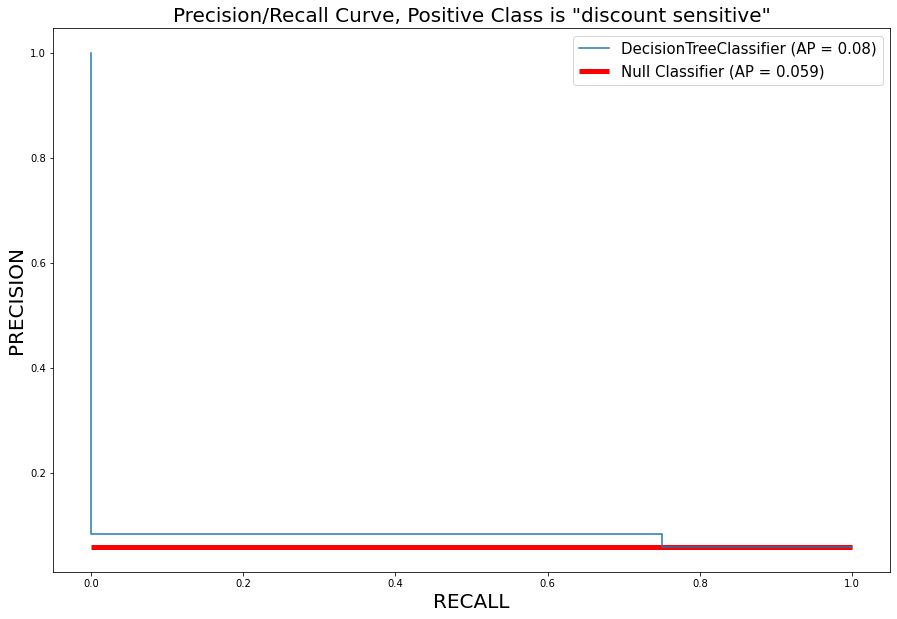

In [158]:
fig = plot_precision_recall_curve(simple_model, X_test, y_test, pos_label=1)
fig.figure_.set_size_inches(15, 10)
plt.hlines(0.059, 0.0, 1.0, colors='red', label="Null Classifier (AP = 0.059)", linewidth=5)
plt.xlabel('RECALL', size='20')
plt.ylabel('PRECISION', size='20')
plt.legend(loc='upper right', fontsize=15)
plt.title('Precision/Recall Curve, Positive Class is "discount sensitive"', size='20')

Text(0.5, 1.0, 'ROC Curve, Positive Class is "discount sensitive"')

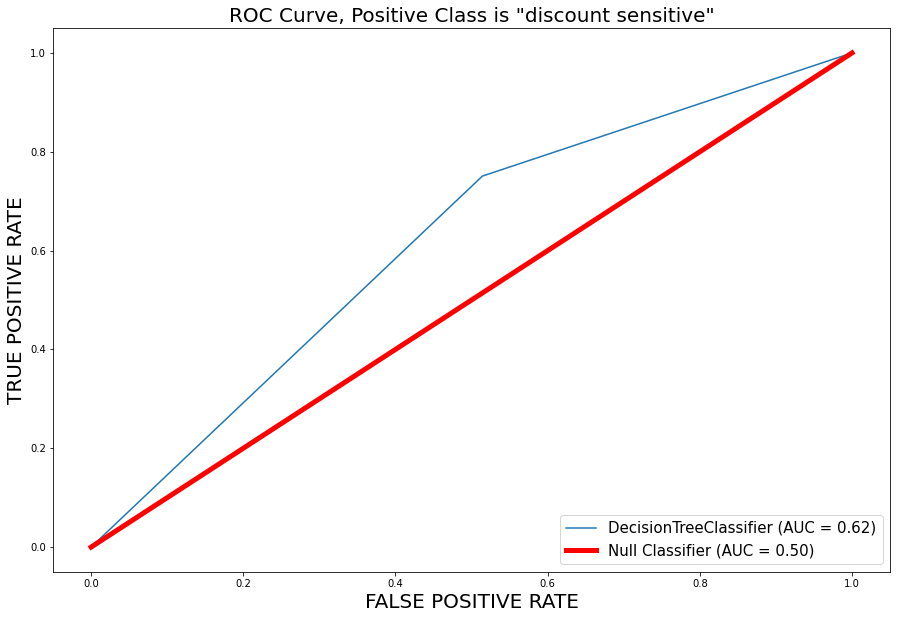

In [159]:
fig = plot_roc_curve(simple_model, X_test, y_test, pos_label=1)
fig.figure_.set_size_inches(15, 10)
fig.ax_.plot([0, 1], [0, 1], 'red', linewidth=5, label="Null Classifier (AUC = 0.50)")
plt.xlabel('FALSE POSITIVE RATE', size='20')
plt.ylabel('TRUE POSITIVE RATE', size='20')
plt.legend(loc='lower right', fontsize=15)
plt.title('ROC Curve, Positive Class is "discount sensitive"', size='20')